In [99]:
import pandas as pd
import clickhouse_connect
import math
import gzip
# connect to ClickHouse GitHub open database
client = clickhouse_connect.get_client(host='play.clickhouse.com', port=443, username='explorer', secure=True)


In [106]:
#Using the repo-level informaiton, create account-level performance metrics
account_df = pd.read_csv('repo_name_login.csv')
output_filename = 'account_level_modified.csv.gz'

header_written = True


In [134]:
accounts = account_df['login'].tolist()
accounts


['microsoft',
 'google',
 'apache',
 'facebookresearch',
 'fossasia',
 'sindresorhus',
 'alibaba',
 'facebook',
 'azure',
 'awslabs',
 'spatie',
 'azkadev',
 'github',
 'googlecloudplatform',
 'mozilla',
 'tencent',
 'packtpublishing',
 'symfony',
 'unity-technologies',
 'dotnet',
 'nvidia',
 'aws-samples',
 'aws',
 'google-research',
 'apple',
 'twitter',
 'codrops',
 'openai',
 'keijiro',
 'mapbox',
 'square',
 'netflix',
 'hashicorp',
 'cloudflare',
 'googlesamples',
 'uber',
 'tensorflow',
 'bradtraversy',
 'shopify',
 'huggingface',
 'nvlabs',
 'lucidrains',
 'opntec',
 'vuejs',
 'polockprog2',
 'jetbrains',
 'quarkiverse',
 'googlechromelabs',
 'linkedin',
 'airbnb',
 'spring-projects',
 'udacity',
 'ibm',
 'firebase',
 'intel',
 'rust-lang',
 'antfu',
 'adrianhajdin',
 'deepmind',
 'ethereum',
 'bytedance',
 'thoughtbot',
 'docker',
 'tc39',
 'spotify',
 'kubernetes-sigs',
 'android',
 'elastic',
 'substack',
 'javaniecampbell',
 'facebookincubator',
 'llsourcell',
 'yahoo',
 'p

In [108]:
for index, account in enumerate(accounts):
    sql_query = f"""
    SELECT
        '{account}' AS account_name,
        toYYYYMM(created_at) AS calendar_month,
        COUNT(commits) AS aggregate_commit_count,
        COUNT(DISTINCT repo_name) AS repository_count,
        COUNT(DISTINCT actor_login) AS contributor_count,
        SUM(if(event_type='ForkEvent', 1, 0)) AS fork_count,
        SUM(if(event_type='WatchEvent', 1, 0)) AS star_count,
        SUM(if(event_type='PullRequestEvent' AND action IN ('closed', 'merged'), 1, 0)) AS pull_request_closures_count,
        SUM(if(event_type='PullRequestEvent' AND action='opened', 1, 0)) AS pull_request_accepted_count,
        SUM(if(event_type='IssuesEvent' AND action='opened', 1, 0)) AS issues_created_count,
        SUM(if(event_type='IssuesEvent' AND action='closed', 1, 0)) AS issues_closed_count,
        COUNT(if(event_type='ReleaseEvent', 1, NULL)) AS releases_count,
        SUM(if(actor_login NOT LIKE '{account}%', 1, 0)) / COUNT(*) AS external_contribution_ratio
    FROM
        github_events
    WHERE
        lower(substring(repo_name, 1, position(repo_name, '/') - 1)) = '{account}'
    GROUP BY
        toYYYYMM(created_at)
    """

    try:
        with client.query_df_stream(sql_query) as df_stream:
            with gzip.open(output_filename, 'at', encoding='utf-8', newline='', compresslevel=9) as f:
                for df in df_stream:
                    df.to_csv(f, index=False, header=False)
        print(f"Batch {index}/250 for account {account} processed and saved.")
    except Exception as e:
        print(f"Error processing account {account}: {e}")
        break

Batch 0/250 for account googlechromelabs processed and saved.
Batch 1/250 for account linkedin processed and saved.
Batch 2/250 for account airbnb processed and saved.
Batch 3/250 for account spring-projects processed and saved.
Batch 4/250 for account udacity processed and saved.
Batch 5/250 for account ibm processed and saved.
Batch 6/250 for account firebase processed and saved.
Batch 7/250 for account intel processed and saved.
Batch 8/250 for account rust-lang processed and saved.
Batch 9/250 for account antfu processed and saved.
Batch 10/250 for account adrianhajdin processed and saved.
Batch 11/250 for account deepmind processed and saved.
Batch 12/250 for account ethereum processed and saved.
Batch 13/250 for account bytedance processed and saved.
Batch 14/250 for account thoughtbot processed and saved.
Batch 15/250 for account docker processed and saved.
Batch 16/250 for account tc39 processed and saved.
Batch 17/250 for account spotify processed and saved.
Batch 18/250 for a

In [162]:
df

,account_name,calendar_month,aggregate_commit_count,repository_count,contributor_count,fork_count,star_count,pull_request_closures_count,pull_request_accepted_count,issues_created_count,issues_closed_count,releases_count,external_contribution_ratio
0,microsoft,202002,158084,1778,38550,7609,28902,6945,6941,9144,8190,406,0.998634
1,microsoft,202207,249848,2605,39692,7057,27643,12813,13197,8930,7921,526,0.994285
2,microsoft,201412,4202,64,986,193,787,164,163,157,104,4,1.000000
3,microsoft,201509,16816,175,4460,1162,3192,775,796,1009,748,22,1.000000
4,microsoft,202402,275581,2611,48295,8219,35487,14996,15155,8526,8210,797,0.922154
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16906,kde,202005,8877,532,547,114,508,5,12,0,0,0,0.073448
16907,kde,201803,6916,509,464,102,440,19,18,0,0,0,0.090659
16908,kde,202305,15672,633,955,127,953,13,14,0,0,0,0.073188
16909,kde,201903,6594,475,454,120,467,6,7,0,0,0,0.093115


In [137]:
for name in accounts:
    sorted = df.loc[df['account_name'] == name]
    sorted.sort_values(by='calendar_month',ascending=True,inplace=True)
    df_sorted = pd.concat([df_sorted,sorted], ignore_index=True)

/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_37541/2558095738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted.sort_values(by='calendar_month',ascending=True,inplace=True)


In [138]:
df_sorted

,account_name,calendar_month,aggregate_commit_count,repository_count,contributor_count,fork_count,star_count,pull_request_closures_count,pull_request_accepted_count,issues_created_count,issues_closed_count,releases_count,external_contribution_ratio
0,microsoft,201406,5,1,3,0,1,0,0,0,0,0,1.000000
1,microsoft,201407,3199,3,1884,125,1836,41,42,125,90,0,1.000000
2,microsoft,201408,2773,5,481,71,341,85,93,159,101,0,1.000000
3,microsoft,201409,3162,10,815,100,690,92,92,136,131,0,1.000000
4,microsoft,201410,3072,48,551,69,375,92,100,151,104,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26089,kde,202405,19873,625,672,94,759,14,12,0,0,0,0.045992
26090,kde,202406,16409,604,701,87,735,3,4,0,0,0,0.051801
26091,kde,202407,13821,577,628,60,653,3,3,0,0,0,0.052601
26092,kde,202408,14641,570,668,62,747,4,3,0,0,0,0.056280


In [139]:
df_sorted['calendar_month'] = pd.to_datetime(df_sorted['calendar_month'], format='%Y%m')
df_sorted['calendar_month'] = df_sorted['calendar_month'].dt.to_period('M')# 

In [158]:
df_sorted.describe()

,aggregate_commit_count,repository_count,contributor_count,fork_count,star_count,pull_request_closures_count,pull_request_accepted_count,issues_created_count,issues_closed_count,releases_count,external_contribution_ratio
count,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000
mean,8416.842761,126.066107,1796.102322,422.091784,1453.969533,407.381275,412.498697,251.479191,210.995171,28.876792,0.930039
std,20180.627580,244.201060,3646.259194,850.347259,3180.940451,1110.374197,1109.917867,873.624918,630.335937,109.590931,0.181882
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,798.000000,32.000000,325.000000,56.000000,252.000000,10.000000,12.000000,14.000000,8.000000,0.000000,0.969074
50%,2614.000000,65.000000,819.000000,161.000000,627.000000,75.000000,79.000000,62.000000,47.000000,3.000000,0.998962
75%,7535.750000,120.000000,1916.000000,422.000000,1465.000000,323.000000,335.750000,213.000000,182.000000,18.000000,1.000000
max,368755.000000,5986.000000,81863.000000,17905.000000,81896.000000,19722.000000,19767.000000,78289.000000,30219.000000,4123.000000,1.000000


In [141]:
top10 = accounts[0:9]
for name in top10:
    sorted = df.loc[df['account_name'] == name]
    sorted.sort_values(by='calendar_month',ascending=True,inplace=True)
    df_top10 = pd.concat([df_top10,sorted], ignore_index=True)

/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_37541/4112317918.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted.sort_values(by='calendar_month',ascending=True,inplace=True)
/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_37541/4112317918.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_top10 = pd.concat([df_top10,sorted], ignore_index=True)


In [146]:
df_pivot_commit = df_sorted.pivot(index='account_name', columns='calendar_month', values='aggregate_commit_count')
df_pivot_dropna=df_pivot_commit.dropna(axis=0,how='any')
df_pivot_commit.fillna(0)

calendar_month,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,...,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09
account_name,,,,,,,,,,,,,,,,,,,,,
1141881632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6lrs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abi-software,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65.0,36.0,11999.0,272.0,198.0,261.0,219.0,320.0,191.0,63.0
abuantar241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
actions,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5729.0,5583.0,5561.0,5762.0,6624.0,6056.0,6337.0,5856.0,5642.0,3783.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xinmrs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xmartysa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yahoo,218.0,457.0,0.0,151.0,353.0,80.0,248.0,83.0,319.0,107.0,...,522.0,526.0,354.0,451.0,647.0,428.0,446.0,597.0,457.0,511.0


In [147]:
df_pivot_commit_top10 = df_top10.pivot(index='account_name', columns='calendar_month', values='aggregate_commit_count')
df_pivot_dropna_commit_top10=df_pivot_commit_top10.dropna(axis=0,how='any')
df_pivot_commit_top10.fillna(0)

/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_37541/2519751420.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot_commit_top10.fillna(0)


calendar_month,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,...,202312,202401,202402,202403,202404,202405,202406,202407,202408,202409
account_name,,,,,,,,,,,,,,,,,,,,,
alibaba,0,0,0,0,0,0,0,0,0,0,...,14754,15256,9933,13324,12450,12068,11150,13303,13146,7191
apache,320,563,624,498,1901,648,683,787,740,772,...,163800,192687,161178,194220,201125,184922,181798,191455,196334,110632
azure,0,0,0,0,0,0,0,0,0,0,...,75361,106149,105994,124702,125267,115118,104274,123746,107745,65457
facebook,1308,2191,2230,2793,3948,2817,2819,2607,2353,2006,...,26518,28229,26748,27435,30549,27306,28000,29623,26331,14944
facebookresearch,0,0,0,0,0,0,0,0,0,0,...,21945,22239,19606,17701,16336,14202,14142,21512,22896,8815
fossasia,0,0,0,0,0,0,0,0,0,0,...,3361,1533,1800,1132,531,2075,2228,2257,1800,551
google,0,0,0,0,0,0,0,0,0,0,...,57643,68190,85557,75521,79408,79527,74102,74795,68035,39572
microsoft,0,0,0,0,0,0,0,0,0,0,...,231508,287289,275581,325004,324282,276204,280165,309620,285408,165821
sindresorhus,0,0,0,0,0,0,0,17,11,9,...,9526,12021,11104,11171,10846,11228,9530,14643,13630,7099


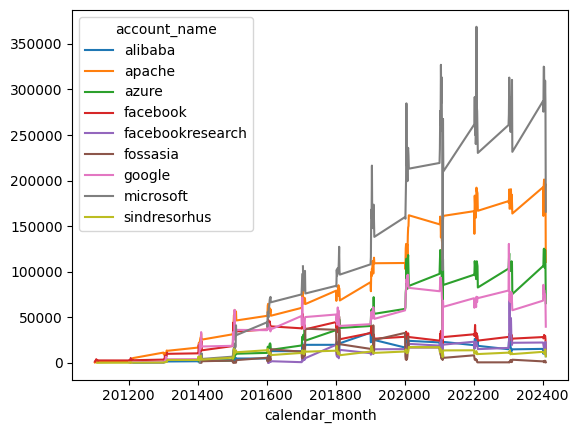

In [148]:
df_commit_top10_transpose = df_pivot_commit_top10.transpose()

# Create the plot without showing the graph
ax = df_commit_top10_transpose.plot(kind='line', marker='')

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

<function matplotlib.pyplot.show(close=None, block=None)>

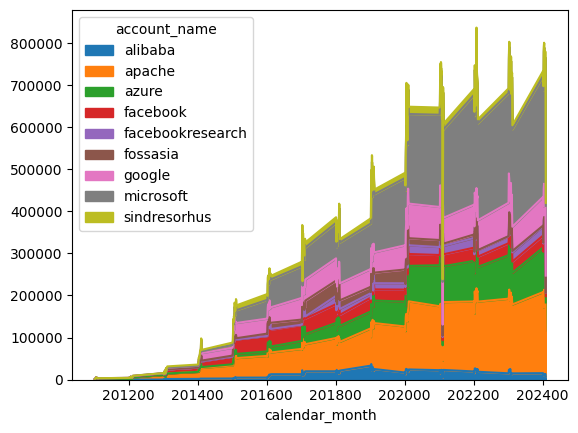

In [151]:
df_commit_top10_transpose.plot(kind='area', stacked=True)

plt.show

In [153]:
df_commit_top10_transpose = df_commit_top10_transpose.apply(pd.to_numeric, errors='coerce')

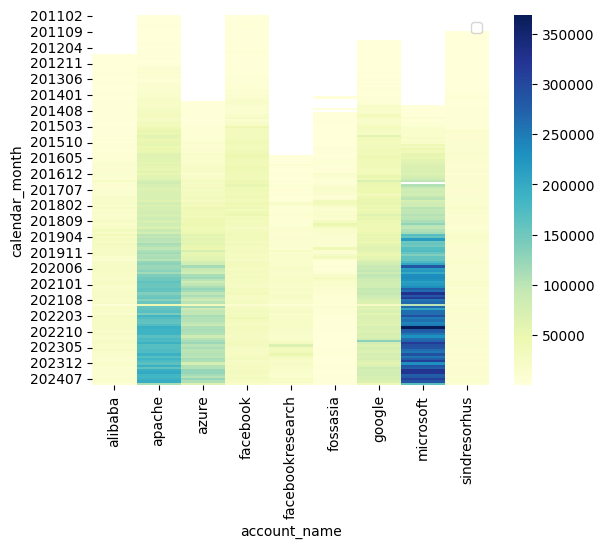

In [154]:
sns.heatmap(df_commit_top10_transpose, cmap="YlGnBu")
plt.legend('aggregate commit count')
plt.show()

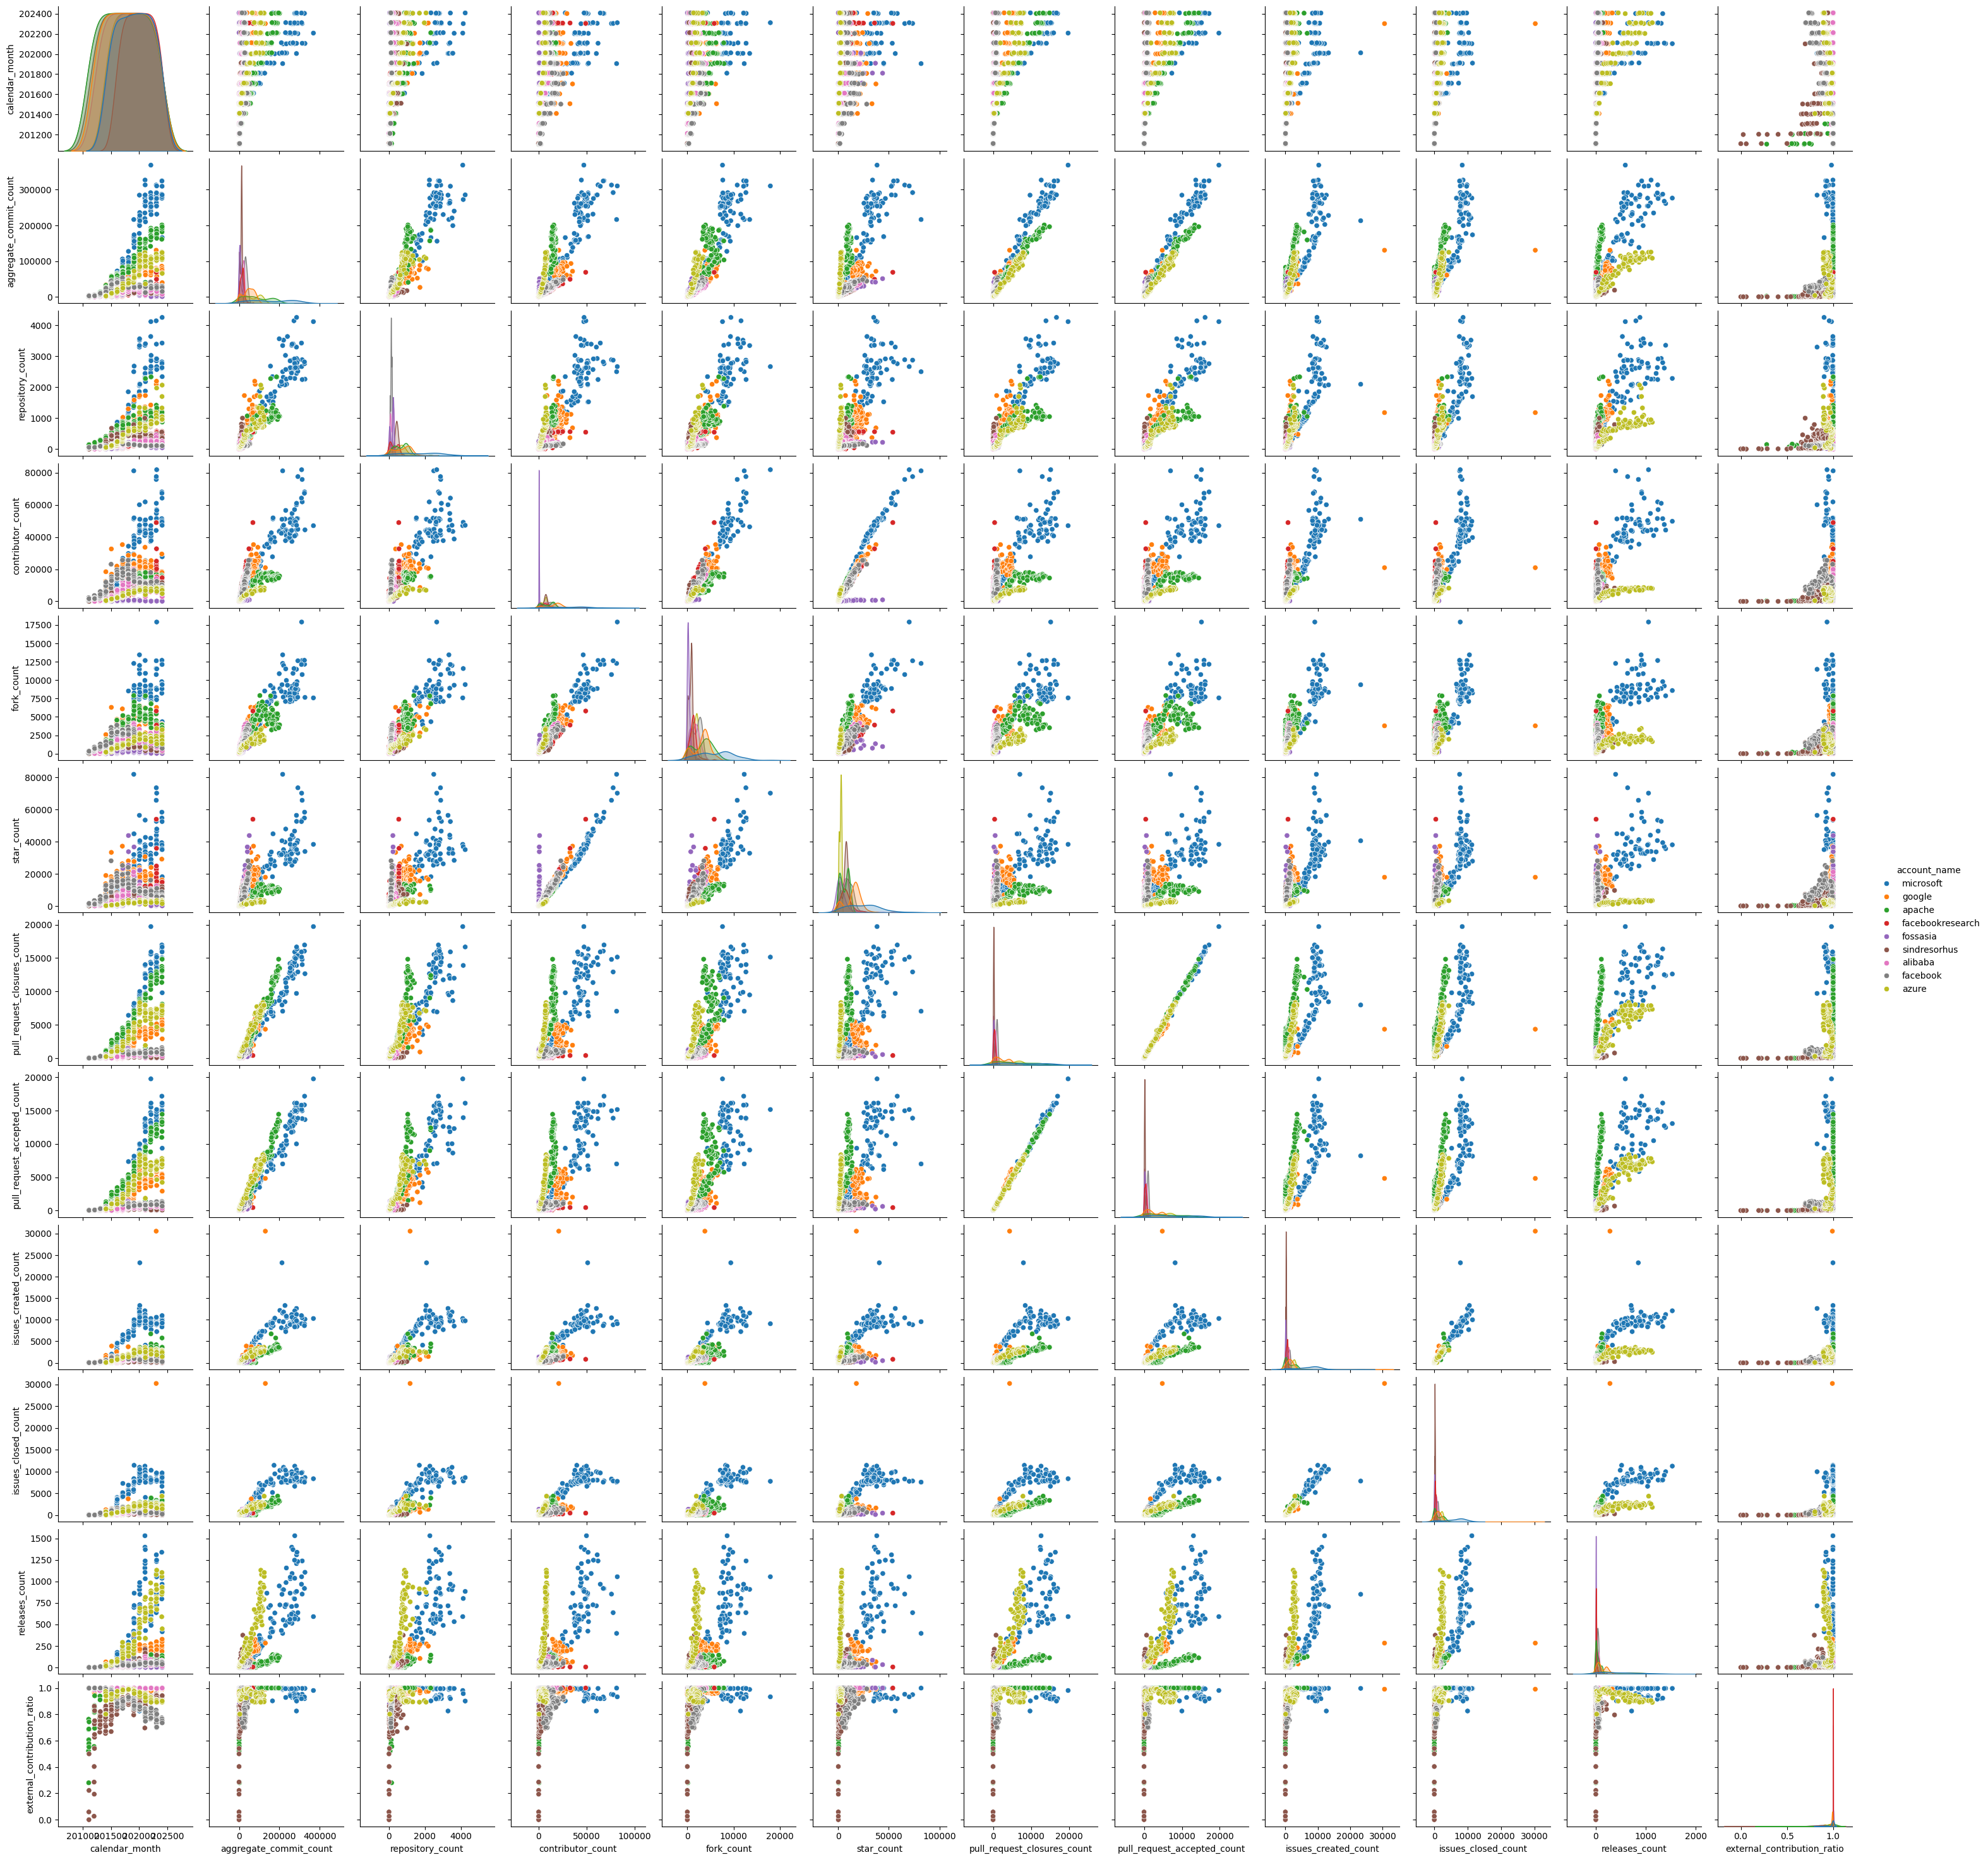

In [155]:
sns.pairplot(df_top10, hue="account_name")
plt.show()

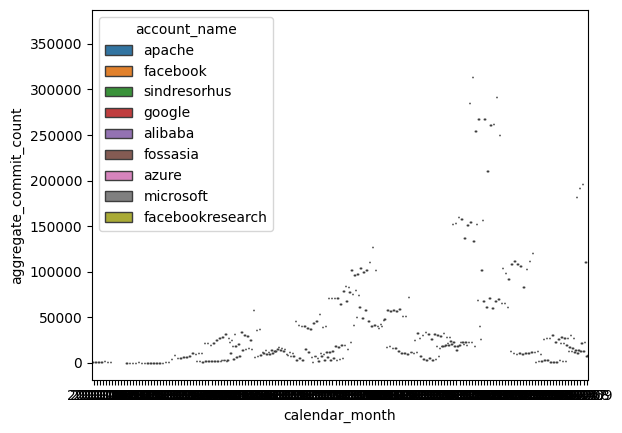

In [156]:
sns.boxplot(data=df_top10, x="calendar_month", y="aggregate_commit_count", hue="account_name")
plt.show()